In [15]:
# import google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# 更改运行目录
import os
# Global path
path = '/content/drive/My Drive/dataif/creating_customer_segments/'
os.chdir(path)

Mounted at /content/drive


## 非监督学习
## 创建用户分类

In [8]:
# 引入这个项目需要的库
import numpy as np
import pandas as pd

# import visuals as vs
from IPython.display import display # 使得我们可以对DataFrame使用display()函数
kagging_fast = False
# 设置以内联的形式显示matplotlib绘制的图片（在notebook中显示更美观）
%matplotlib inline
# 高分辨率显示
# %config InlineBackend.figure_format='retina'

# 载入整个客户数据集
data = pd.read_csv(path + "customers.csv")
data.drop(['Region', 'Channel'], axis = 1, inplace = True)
print("数据集总共用 {} 样本，每个样本有 {} 个特征".format(*data.shape))

数据集总共用 440 样本，每个样本有 6 个特征


In [0]:
%load visuals.py
import visuals as vs

## 分析数据
在这部分，开始分析数据，通过可视化和代码来理解每一个特征和其他特征的联系。关于数据集的统计描述，考虑每一个属性的相关性，然后从数据集中选择若干个样本数据点，在整个项目中一直跟踪研究这几个数据点。


In [21]:
# 显示数据集的一个描述
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### 选择样本
为了对客户有一个更好的了解，并且了解代表他们的数据将会在这个分析过程中如何变换。最好是选择几个样本数据点，并且更为详细地分析它们。在下面，选择**三个**索引加入到索引列表`indices`中，找到三个明显不同的客户,这三个索引代表要追踪的客户。

In [0]:
# print(data.head(5), '\n')

display(data.sample(3).reset_index(drop=True))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,7388,1882,2174,720,47,537
1,7034,1492,2405,12569,299,1117
2,56083,4563,2124,6422,730,3321


In [0]:
# 从数据集中选择三个你希望抽样的数据点的索引
indices = [14, 341, 411]

# 为选择的样本建立一个DataFrame
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,24653,9465,12091,294,5058,2168
1,2320,5763,11238,767,5162,2158
2,2126,3289,3281,1535,235,4365


### 特征相关性
一个有趣的想法是，考虑这六个类别中的一个（或者多个）产品类别，是否对于理解客户的购买行为具有实际的相关性。也就是说，当用户购买了一定数量的某一类产品，我们是否能够确定他们必然会成比例地购买另一种类的产品。有一个简单的方法可以检测相关性：我们用移除了某一个特征之后的数据集来构建一个监督学习（回归）模型，然后用这个模型去预测那个被移除的特征，再对这个预测结果进行评分，看看预测结果如何。


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

def get_r2score(data, drop_feature):
    # drop_feature = 'Milk'

    # 为DataFrame创建一个副本，用'drop'函数丢弃一个特征# 
    new_data = data.drop(drop_feature, axis=1)
    # 使用给定的特征作为目标，将数据分割成训练集和测试集    
    X_train, X_test, y_train, y_test = train_test_split(
        new_data, data[[drop_feature]], test_size=.25, random_state=0)
    # 创建一个DecisionTreeRegressor（决策树回归器）并在训练集上训练它
    regressor = DecisionTreeRegressor()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    # 输出在测试集上的预测得分
    score = r2_score(y_test, y_pred)
    print(drop_feature, score)
    return score

In [0]:
for col in data.columns:
    get_r2score(data, col)

Fresh -0.4111193427706987
Milk 0.24580441967774702
Grocery 0.6414145142181493
Frozen 0.2296538182104707
Detergents_Paper 0.7322461444903512
Delicatessen -13.421929070127353


### 可视化特征分布
为了能够对这个数据集有一个更好的理解，我们可以对数据集中的每一个产品特征构建一个散布矩阵（scatter matrix）。

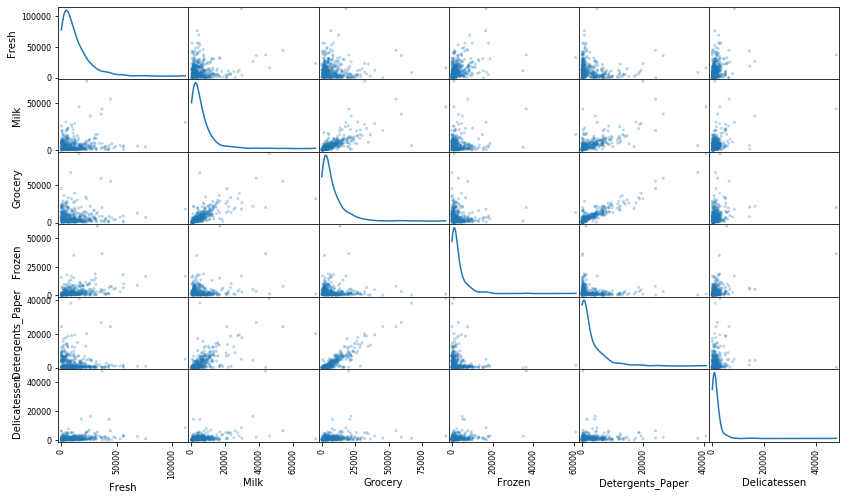

In [0]:
# 对于数据中的每一对特征构造一个散布矩阵
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## 数据预处理
在这个部分，将通过在数据上做一个合适的缩放，并检测异常点（选择性移除）将数据预处理成一个更好的代表客户的形式。预处理数据是保证在分析中能够得到显著且有意义的结果的重要环节。

### 特征缩放
如果数据不是正态分布的，尤其是数据的平均数和中位数相差很大的时候（表示数据非常歪斜）。这时候通常用一个[非线性的缩放](https://github.com/czcbangkai/translations/blob/master/use_of_logarithms_in_economics/use_of_logarithms_in_economics.pdf)是很合适的，[（英文原文）](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) — 尤其是对于金融数据。一种实现这个缩放的方法是使用 [Box-Cox 变换](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html)，这个方法能够计算出能够最佳减小数据倾斜的指数变换方法。一个比较简单的并且在大多数情况下都适用的方法是使用自然对数。

在下面的代码单元中，你将需要实现以下功能：
 - 使用 `np.log` 函数在数据 `data` 上做一个对数缩放，然后将它的副本（不改变原始data的值）赋值给 `log_data`。 
 - 使用 `np.log` 函数在样本数据 `samples` 上做一个对数缩放，然后将它的副本赋值给 `log_samples`。

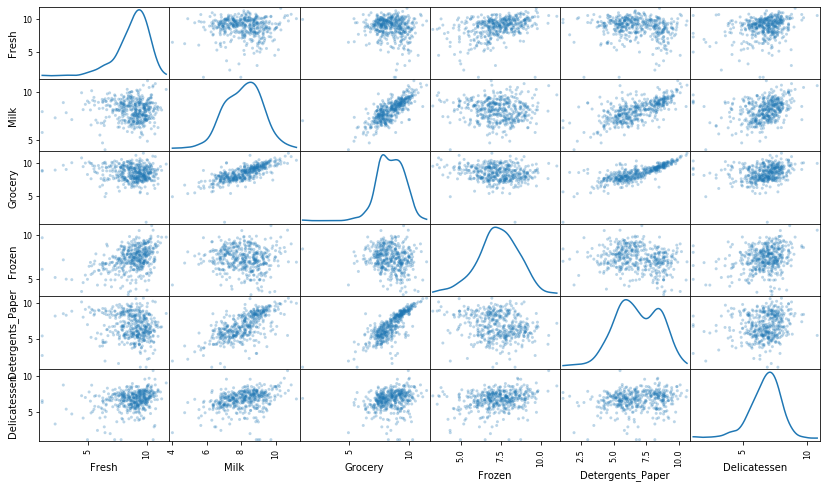

In [0]:
# 使用自然对数缩放数据
log_data = np.log(data)
# 使用自然对数缩放样本数据
log_samples = np.log(samples)
# 为每一对新产生的特征制作一个散射矩阵
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### 观察
在使用了一个自然对数的缩放之后，数据的各个特征会显得更加的正态分布。

In [0]:
# 展示经过对数变换后的样本数据
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.112654,9.155356,9.400217,5.683580,8.528726,7.681560
1,7.749322,8.659213,9.327056,6.642487,8.549079,7.676937
2,7.661998,8.098339,8.095904,7.336286,5.459586,8.381373


### 异常值检测
对于任何的分析，在数据预处理的过程中检测数据中的异常值都是非常重要的一步。异常值的出现会使得把这些值考虑进去后结果出现倾斜。这里有很多关于怎样定义什么是数据集中的异常值的经验法则。这里我们将使用[ Tukey 的定义异常值的方法](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/)：一个异常阶（outlier step）被定义成1.5倍的四分位距（interquartile range，IQR）。一个数据点如果某个特征包含在该特征的 IQR 之外的特征，那么该数据点被认定为异常点。


In [0]:
print(log_data.keys())
log_data.columns

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper',
       'Delicatessen'],
      dtype='object')


Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper',
       'Delicatessen'],
      dtype='object')

In [0]:
# 对于每一个特征，找到值异常高或者是异常低的数据点
for feature in log_data.keys():
    
    # 计算给定特征的Q1（数据的25th分位点）
    Q1 = np.percentile(log_data[feature], 25)
    
    # 计算给定特征的Q3（数据的75th分位点）
    Q3 = np.percentile(log_data[feature], 75)
    
    # 使用四分位范围计算异常阶（1.5倍的四分位距）
    step = 1.5 * (Q3 - Q1)
    
    # 显示异常点
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
# 选择希望移除的数据点的索引
outliers = [65,66,75,128,154]

# 以下代码会移除outliers中索引的数据点, 并储存在good_data中
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


## 特征转换
在这个部分中你将使用主成分分析（PCA）来分析批发商客户数据的内在结构。由于使用PCA在一个数据集上会计算出最大化方差的维度，我们将找出哪一个特征组合能够最好的描绘客户。

### 主成分分析（PCA）

既然数据被缩放到一个更加正态分布的范围中并且也移除了需要移除的异常点，现在就能够在 `good_data` 上使用PCA算法以发现数据的哪一个维度能够最大化特征的方差。除了找到这些维度，PCA 也将报告每一个维度的解释方差比（explained variance ratio）--这个数据有多少方差能够用这个单独的维度来解释。注意 PCA 的一个组成部分（维度）能够被看做这个空间中的一个新的“特征”，但是它是原来数据中的特征构成的。


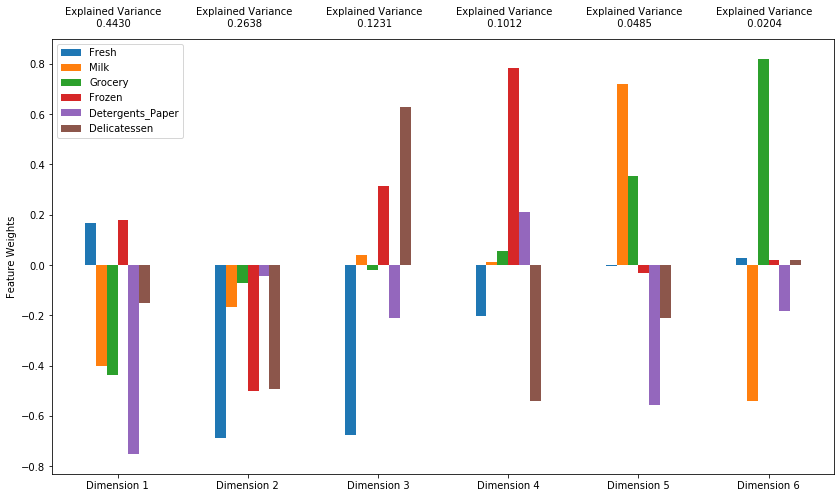

In [0]:
# 通过在good data上进行PCA，将其转换成6个维度
from sklearn.decomposition import PCA
pca = PCA(n_components=6).fit(good_data)

# 使用上面的PCA拟合将变换施加在log_samples上
# pca_samples = None
pca_samples = pca.transform(log_samples)

# 生成PCA的结果图
pca_results = vs.pca_results(good_data, pca)

In [0]:
# 展示经过PCA转换的sample log-data
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-2.3388,-0.9013,-1.1515,-1.6713,-0.0485,-0.0739
1,-2.3471,0.3294,0.7258,-0.4389,-0.4673,0.0810
2,0.7424,0.0059,2.1018,-0.9815,0.2461,-0.0371


### 降维
当使用主成分分析的时候，一个主要的目的是减少数据的维度，这实际上降低了问题的复杂度。当然降维也是需要一定代价的：更少的维度能够表示的数据中的总方差更少。因为这个，**累计解释方差比（cumulative explained variance ratio）**对于我们确定这个问题需要多少维度非常重要。另外，如果大部分的方差都能够通过两个或者是三个维度进行表示的话，降维之后的数据能够被可视化。


In [0]:
# 通过在good data上进行PCA，将其转换成两个维度
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(good_data)

# 使用上面训练的PCA将good data进行转换
reduced_data = pca.transform(good_data)

# 使用上面训练的PCA将log_samples进行转换
pca_samples = pca.transform(log_samples)
# 为降维后的数据创建一个DataFrame
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [0]:
# 展示经过两个维度的PCA转换之后的样本log-data
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-2.3388,-0.9013
1,-2.3471,0.3294
2,0.7424,0.0059


## 可视化一个双标图（Biplot）
双标图是一个散点图，每个数据点的位置由它所在主成分的分数确定。坐标系是主成分（这里是 `Dimension 1` 和 `Dimension 2`）。此外，双标图还展示出初始特征在主成分上的投影。一个双标图可以帮助我们理解降维后的数据，发现主成分和初始特征之间的关系。


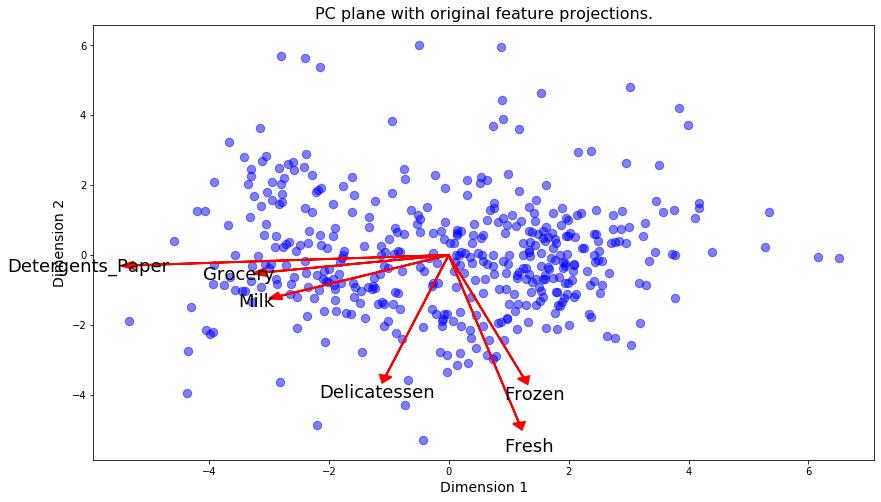

In [0]:
# 可视化双标图
vs.biplot(good_data, reduced_data, pca);

## 聚类

在这个部分，你讲选择使用 K-Means 聚类算法或者是高斯混合模型聚类算法以发现数据中隐藏的客户分类。然后将从簇中恢复一些特定的关键数据点，通过将它们转换回原始的维度和规模，从而理解他们的含义。

### 创建聚类

针对不同情况，有些问题你需要的聚类数目可能是已知的。但是在聚类数目不作为一个**先验**知道的情况下，我们并不能够保证某个聚类的数目对这个数据是最优的，因为我们对于数据的结构（如果存在的话）是不清楚的。但是，我们可以通过计算每一个簇中点的**轮廓系数**来衡量聚类的质量。数据点的[轮廓系数](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)衡量了它与分配给他的簇的相似度，这个值范围在-1（不相似）到1（相似）。**平均**轮廓系数为我们提供了一种简单地度量聚类质量的方法。


In [0]:
clusterer = GaussianMixture(n_components=2, random_state=3)
clusterer.fit(reduced_data)
# 预测每一个点的簇
preds = clusterer.predict(reduced_data)
# 找到聚类中心
centers = clusterer.means_
# 预测在每一个转换后的样本点的类
sample_preds = clusterer.predict(pca_samples)
# 计算选择的类别的平均轮廓系数（mean silhouette coefficient）
from sklearn.metrics import silhouette_score
score = silhouette_score(reduced_data, preds)
print(n_components, score)

In [0]:
# 在降维后的数据上使用你选择的聚类算法
from sklearn.mixture import GaussianMixture
def get_silhouette(reduced_data, n_components):
    clusterer = GaussianMixture(n_components=n_components, random_state=3)
    clusterer.fit(reduced_data)
    # 预测每一个点的簇
    
    preds = clusterer.predict(reduced_data)
    # 找到聚类中心
    
    centers = clusterer.means_
    # 预测在每一个转换后的样本点的类
    
    sample_preds = clusterer.predict(pca_samples)
    # TODO：计算选择的类别的平均轮廓系数（mean silhouette coefficient）
    
    from sklearn.metrics import silhouette_score
    score = silhouette_score(reduced_data, preds)
    print(n_components, score)

    return score

In [0]:
for n in range(2, 9):
    get_silhouette(reduced_data, n)

2 0.4219168464626149
3 0.37553218893793083
4 0.28762713951391866
5 0.33758544467039175
6 0.31496839707083024
7 0.321064366127049
8 0.3047007413058301


### 聚类可视化
一旦你选好了通过上面的评价函数得到的算法的最佳聚类数目，就能够通过使用下面的代码块可视化来得到的结果。作为实验，可以试着调整聚类算法的聚类的数量来看一下不同的可视化结果。但是最终的可视化图像必须和你选择的最优聚类数目一致。

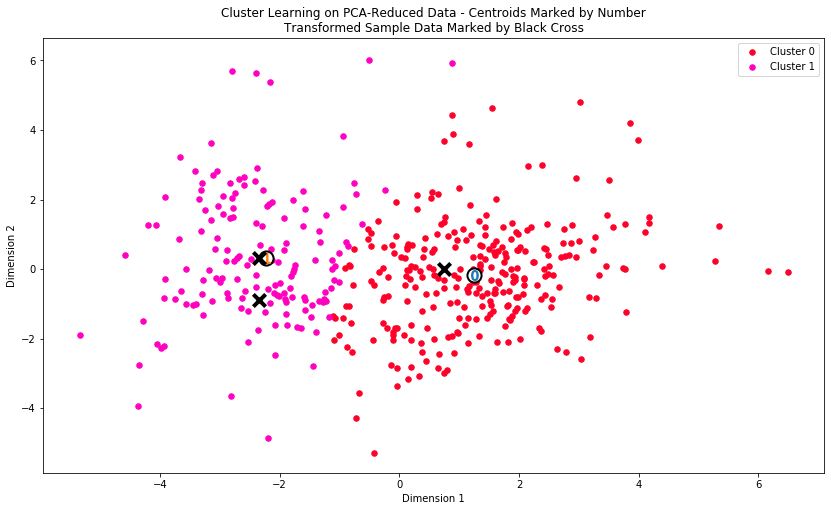

In [0]:
# 从已有的实现中展示聚类的结果
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### 数据恢复
上面的可视化图像中提供的每一个聚类都有一个中心点。这些中心（或者叫平均点）并不是数据中真实存在的点，但是是所有预测在这个簇中的数据点的平均。对于创建客户分类的问题，一个簇的中心对应于那个分类的平均用户。因为这个数据现在进行了降维并缩放到一定的范围，我们可以通过施加一个反向的转换恢复这个点所代表的用户的花费。




In [0]:
# 反向转换中心点
log_centers = pca.inverse_transform(centers)

# 对中心点做指数转换
true_centers = np.exp(log_centers)

# 显示真实的中心点
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8953.0,2114.0,2765.0,2075.0,353.0,732.0
Segment 1,3552.0,7837.0,12219.0,870.0,4696.0,962.0


## 后续工作

最后，使用已经被分类的数据。首先，你要考虑不同组的客户**客户分类**，针对不同的派送策略受到的影响会有什么不同。其次，你要考虑到，每一个客户都被打上了标签（客户属于哪一个分类）可以给客户数据提供一个多一个特征。然后，把客户分类与一个数据中的隐藏变量做比较，看一下这个分类是否辨识了特定的关系。